# Ziad Al-Ziadi

## Facial Emotion Recognition with MLP and HOG (Histogram of Oriented Gradients)

In the preceding section, we will implement several variations of a Facial Emotion Recognition (FER) solution. It will include a Multi-Layered Perceptron (MLP). The MLP will be used with HOG and will make use of the Real-world Affective Faces (RAF) dataset consisting of facial images that depcit emotions that are labeled as:

1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral

Ultimately, the objective is to have the MLP accurately predict the emotions in unseen images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from skimage import exposure
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from skimage.exposure import equalize_hist, equalize_adapthist

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
zip_path = "/content/drive/MyDrive/CV_Submission/CW_Dataset.zip"
!cp "{zip_path}" .
!yes|unzip -q CW_Dataset.zip

In [ ]:
# Creating the test and trian path

train_image_path = "/content/train"
test_image_path = "/content/test"

train_txt = "/content/labels/list_label_train.txt"
test_txt = "/content/labels/list_label_test.txt"

# Creating a dataframe from our label txt files

colnames = ["Image_id", "Label"]
train_lab = pd.read_csv(train_txt, names = colnames, header = None, delim_whitespace = True)
test_lab = pd.read_csv(test_txt, names = colnames, header = None, delim_whitespace = True)

In [ ]:
# Here, I'm cleaning the label string to isolate the label value

train_lab["Image_id"] = train_lab["Image_id"].apply(lambda i: i[:-4])
test_lab["Image_id"] = test_lab["Image_id"].apply(lambda i: i[:-4])

# I append the string "_aligned.jpg" so that it matches our image names

train_lab["Image_id"] = train_lab["Image_id"] + "_aligned.jpg"
test_lab["Image_id"] = test_lab["Image_id"] + "_aligned.jpg"

# Here, I carry out a little bit of renidexing: note I have to +1 after to maintain correct label value

train_lab["Label"] = train_lab["Label"].apply(lambda i: i - 1)
train_lab["Label"] = train_lab["Label"].apply(lambda i: i + 1)

test_lab["Label"] = test_lab["Label"].apply(lambda i: i - 1)
test_lab["Label"] = test_lab["Label"].apply(lambda i: i + 1)

In [ ]:
#This function takes a dataframe and applies the HOG descriptor

def hog_des(data_frame):

  hog_img = []
  labels = []

  for i, row in data_frame.iterrows():
    img_path = "/content/train/"
    img_name = row[0]
    lbl = row[1]

    img_path += str(img_name)
    img = cv2.imread(img_path)
    hog_des = hog(img, orientations = 8, pixels_per_cell = (14, 14),
                  cells_per_block = (1,1), visualize = False)
    # kp, des = hog.detectAndCompute(img, None)
    # kp, des = orb.compute(img, kp)
    if hog_des is not None:
      hog_img.append(hog_des)
      labels.append(lbl)
  hog_array = np.vstack(hog_img)

  return hog_array, labels

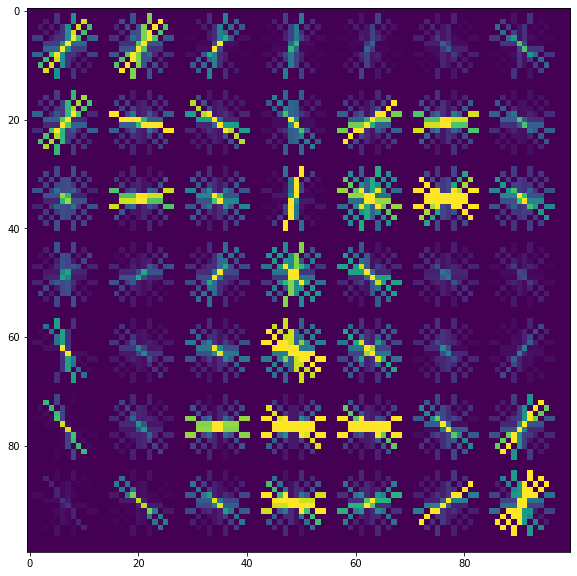

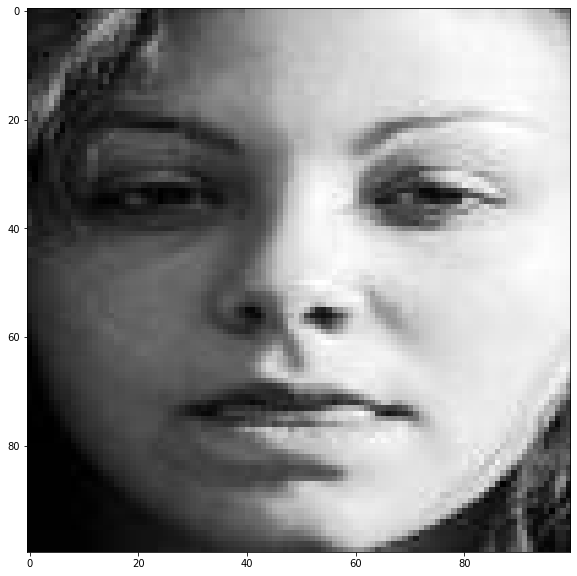

In [ ]:
for i, row in train_lab.iterrows():
  img_path = "/content/train/"
  img_name = row[0]

  img_path += str(img_name)
  img = cv2.imread(img_path)
  _, hog_img= hog(img, orientations = 8, pixels_per_cell = (14, 14),
                  cells_per_block = (1,1), visualize = True)
  HOG_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))

plt.figure(figsize=(10,10))
plt.imshow(HOG_image_rescaled)
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

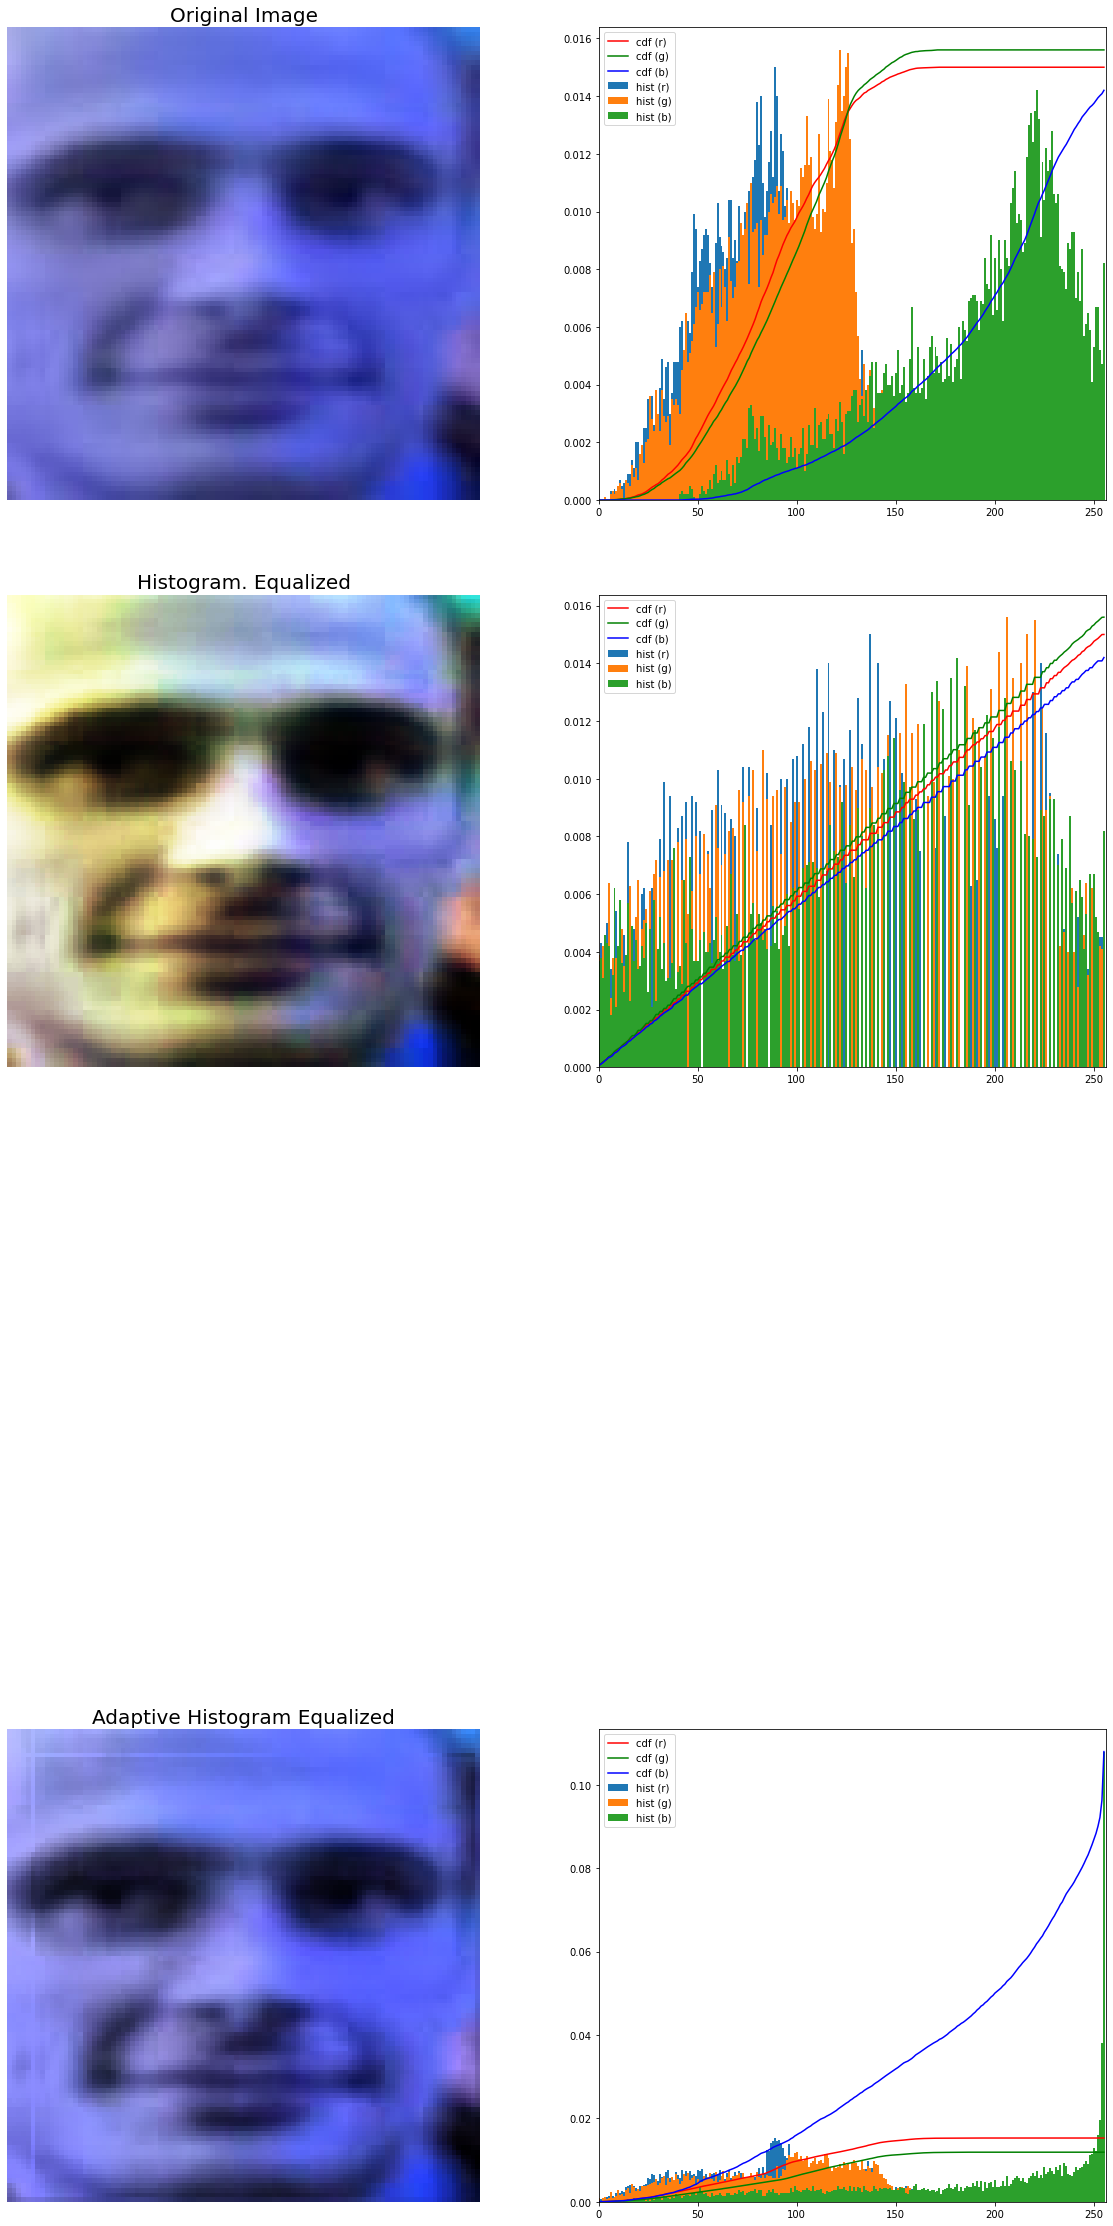

In [ ]:
# Here, we plot a random chosen coloured image to visualise it as a histogram.
# Although not necessary, it provides a better understanding of how HOG makes 
# use of histograms in an image

img = cv2.imread("/content/train/train_00008_aligned.jpg")

plt.figure(figsize=(20,40))

def plot_image(image, title):
    plt.imshow(image)
    plt.title(title, size=20)
    plt.axis('off')
    
def plot_hist(img):
    colors = ['r', 'g', 'b']
    cdf = np.zeros((256,3))
    for i in range(3):
        hist, bins = np.histogram(img[...,i].flatten(),256,[0,256], normed=True)
        cdf[...,i] = hist.cumsum()
        cdf_normalized = cdf[...,i] * hist.max() / cdf.max()
        plt.plot(cdf_normalized, color = colors[i], label='cdf ({})'.format(colors[i]))
        #plt.hist(img[...,i].flatten(),256,[0,256], color = colors[i], density=True)
        binWidth = bins[1] - bins[0]
        plt.bar(bins[:-1], hist*binWidth, binWidth, label='hist ({})'.format(colors[i]))
        plt.xlim([0,256])
    plt.legend(loc = 'upper left')
    return cdf

plt.subplot(421), plot_image(img, 'Original Image')
plt.subplot(422) 
cdf = plot_hist(img)

img2 = np.copy(img)
for i in range(3):
    cdf_m = np.ma.masked_equal(cdf[...,i],0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    #cdf_m = 255 * cdf / cdf[-1] # normalize
    cdf2 = np.ma.filled(cdf_m,0).astype('uint8')
    img2[...,i] = cdf2[img[...,i]]

plt.subplot(423), plot_image(img2, 'Histogram. Equalized')
plt.subplot(424), plot_hist(img2)

equ = (255*equalize_adapthist(img)).astype(np.uint8)
plt.subplot(427), plot_image(equ, 'Adaptive Histogram Equalized')
plt.subplot(428), plot_hist(equ)
plt.show()

In [ ]:
# Applying HOG to our training set dataframe

hog_train, hog_train_lab = hog_des(train_lab)
X_train, _, y_train, _ = train_test_split(hog_train, hog_train_lab, test_size = 0.1, shuffle=True)

#Initialising our first MLP 

clf = MLPClassifier(
    hidden_layer_sizes = (100),
    activation = "relu",
    solver = "adam",
    alpha = 1e-5,
    batch_size = 64,
    learning_rate = "constant",
    shuffle = True,
    momentum = 0.7,
    early_stopping = True
)

In [ ]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size=64, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=100, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.7, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# Once our MLP has been trained on our training set, we can evaluate on our test

#Reading in test data with the same as function as before but with test path instead

def hog_des_test(data_frame):

  hog_img = []
  labels = []

  for i, row in data_frame.iterrows():
    img_path = "/content/test/"
    img_name = row[0]
    lbl = row[1]

    img_path += str(img_name)
    img = cv2.imread(img_path)
    hog_des = hog(img, orientations = 8, pixels_per_cell = (14, 14),
                  cells_per_block = (1,1), visualize = False)
    # kp, des = hog.detectAndCompute(img, None)
    # kp, des = orb.compute(img, kp)
    if hog_des is not None:
      hog_img.append(hog_des)
      labels.append(lbl)
  hog_array = np.vstack(hog_img)

  return hog_array, labels

hog_test, hog_test_lab = hog_des_test(test_lab)

_, X_test, _, y_test = train_test_split(hog_test, hog_test_lab, test_size = .99, shuffle=True)

In [ ]:
#Prediciting on test data

clf_pred = clf.predict(X_test).tolist()

In [ ]:
print(f"""Classification report for classifier {clf}:
      {classification_report(y_test, clf_pred)}\n""")

Classification report for classifier GridSearchCV(cv=2, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=500, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
      

We can see that our MLP used with HOG has performed similarly to our SVM with HOG, although 5% lower on accuracy. This came as a surprise given that MLPs are more comprehensive than SVMs. That being said, MLPs are notoriously tricky to tune adn adjust. Therefore, running a grid search is the next logical step. Furthermore, this keep in line with our SVM implementation. 

In [ ]:
mlp_params = {
    'hidden_layer_sizes': [(50,), (70,), (100,)],
    'activation': ["tanh",'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
# The scores our MLP will use

mlp = MLPClassifier(max_iter = 500)

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        mlp, mlp_params, scoring='%s_macro' % score,  cv =2, n_jobs = -1
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on training set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Classification report for Train set:")
    print()
    y_true_train, y_pred_train = y_train, clf.predict(X_train)
    print(classification_report(y_true_train, y_pred_train))
    print()

    print("Classification report for Test set:")
    print()
    y_test_, y_pred_test = y_test, clf.predict(X_test)
    print(classification_report(y_test_, y_pred_test))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on training set:

{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}

Grid scores on training set:

0.437 (+/-0.013) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
0.441 (+/-0.012) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.445 (+/-0.022) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (70,), 'learning_rate': 'constant', 'solver': 'adam'}
0.444 (+/-0.003) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (70,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.450 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.430 (+/-0.042) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10

The MLP with HOG applied has outperformed the MLPs that made use of other feature descriptors, ORB and SIFT. Therefore, this is our most optimal MLP.

In [ ]:
import pickle

with open("hog_mlp.pkl", "wb") as hog_mlp:
    pickle.dump(clf, hog_mlp)